In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#Loading libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.utils import np_utils
import random
from tensorflow.keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

#../input/flickerdata/Flickr_Data/Flickr_TextData
images_dir = os.listdir("./")

images_path = '../input/flickerdata/Flickr_Data/Images/'
captions_path = '../input/flickerdata/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '../input/flickerdata/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '../input/flickerdata/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '../input/flickerdata/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

print("Working 0")

Working 0


In [6]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

print("Working 1 ")

# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

Working 1 


18

In [7]:
print("Working 2")

# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

print("Working 3")

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

print("Working 4")

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

Working 2
Working 3
Working 4


In [8]:
print("Working 5")

# Loading 50 layer Residual Network Model and getting the summary of the model
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

print("Working 6 ")

train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

print("Working 7")

# opening train_encoded_images.p file and dumping it's content
with open("train_encoded_images.p", "wb") as pickle_f:
    pickle.dump(train_data, pickle_f )

Working 5
94773248/94765736 [==============================] - 1s 0us/step
Working 6 
1000
2000
3000
Working 7


In [9]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

print("Working 8")

# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

print("Working 9")
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))
vocab_size = len(unique)

# Vectorization
print("Working 10")
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

vocab_size = len(word_2_indices.keys())
print(vocab_size)

max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)


print("Working 11")
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

for ix in range(len(padded_sequences[5])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[5][ix][iy]],)
    print("\n")

print(len(padded_sequences[5]))

print("Working 12")

num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(30000, 2)
Working 8
30000
Working 9
8253
Working 10
6585
khakis
5321
innertube
8254
40
Working 11
(30000,)
(30000,)
<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
baby
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
baby
plays
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
little
baby
plays
croquet
UNK
UNK
UNK


In [10]:
print("Working 13")

with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

images = []
for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
images = np.asarray(images)
np.save("images.npy", images)

print(images.shape)

image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)
print(len(image_names))

Working 13
(15000, 2048)
(25493, 2048)
25493


In [11]:
#Model
print("Working 14")

captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

images = np.load("images.npy")
print(images.shape)

imag = np.load("image_names.npy")
print(imag.shape)

Working 14
(25493, 40)
(25493, 8254)
(25493, 2048)
(25493,)


In [12]:
embedding_size = 128
max_len = 40
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

print(image_model.summary())

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

print("Working 15")
print(language_model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
None
Working 15
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           32896     
Total params

In [13]:

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
print(model.summary())

model.fit([images, captions], next_words, batch_size=512, epochs=200)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
_______________________________________________________________________________________

50/50 [==============================] - 4s 80ms/step - loss: 1.8152 - accuracy: 0.5028
Epoch 53/200
50/50 [==============================] - 4s 80ms/step - loss: 1.7779 - accuracy: 0.5068
Epoch 54/200
50/50 [==============================] - 4s 82ms/step - loss: 1.7418 - accuracy: 0.5150
Epoch 55/200
50/50 [==============================] - 4s 82ms/step - loss: 1.6948 - accuracy: 0.5226
Epoch 56/200
50/50 [==============================] - 4s 79ms/step - loss: 1.6439 - accuracy: 0.5337
Epoch 57/200
50/50 [==============================] - 4s 81ms/step - loss: 1.6038 - accuracy: 0.5418
Epoch 58/200
50/50 [==============================] - 4s 80ms/step - loss: 1.5728 - accuracy: 0.5459
Epoch 59/200
50/50 [==============================] - 4s 80ms/step - loss: 1.5171 - accuracy: 0.5616
Epoch 60/200
50/50 [==============================] - 4s 82ms/step - loss: 1.4795 - accuracy: 0.5675
Epoch 61/200
50/50 [==============================] - 4s 81ms/step - loss: 1.4473 - accuracy: 0.5726
Epo

50/50 [==============================] - 4s 80ms/step - loss: 0.3568 - accuracy: 0.8736
Epoch 133/200
50/50 [==============================] - 4s 79ms/step - loss: 0.3483 - accuracy: 0.8788
Epoch 134/200
50/50 [==============================] - 4s 85ms/step - loss: 0.3475 - accuracy: 0.8772
Epoch 135/200
50/50 [==============================] - 4s 84ms/step - loss: 0.3446 - accuracy: 0.8777
Epoch 136/200
50/50 [==============================] - 4s 83ms/step - loss: 0.3315 - accuracy: 0.8840
Epoch 137/200
50/50 [==============================] - 4s 80ms/step - loss: 0.3398 - accuracy: 0.8806
Epoch 138/200
50/50 [==============================] - 4s 79ms/step - loss: 0.3372 - accuracy: 0.8797
Epoch 139/200
50/50 [==============================] - 4s 81ms/step - loss: 0.3308 - accuracy: 0.8827
Epoch 140/200
50/50 [==============================] - 4s 79ms/step - loss: 0.3290 - accuracy: 0.8821
Epoch 141/200
50/50 [==============================] - 4s 81ms/step - loss: 0.3313 - accuracy: 0

In [14]:
import pickle

with open('word_2_indices.pickle', 'wb') as handle:
    pickle.dump(word_2_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
import pickle

with open('indices_2_word.pickle', 'wb') as handle:
    pickle.dump(indices_2_word, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
#model.
#model.save('./model_caption')

import tensorflow as tf
tf.keras.models.save_model(model, "saved_model.hp5", save_format="h5")

### Predictions

In [ ]:
from tensorflow import keras
from keras import models


saved_model = keras.models.load_model('/content/drive/My Drive/EAI Project/caption_generator/saved_model.hp5')

In [ ]:
#loading the word_2_indices pickle file
with open('/content/drive/My Drive/EAI Project/caption_generator/word_2_indices.pickle', 'rb') as handle:
     word_2_indices_data = pickle.load(handle)

word_2_indices = word_2_indices_data

#loading the indices_2_word pickle file
with open('/content/drive/My Drive/EAI Project/caption_generator/indices_2_word.pickle', 'rb') as handle:
    indices_2_word_data = pickle.load(handle)

indices_2_word = indices_2_word_data

[0.24713594 1.4790553  0.2677395  ... 1.2451994  0.08989363 0.20778008]
par_caps [8151]

par_caps2 [[8151    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]

preds [[5.29788338e-07 1.05282595e-07 1.18790995e-08 ... 1.12755592e-08
  1.14207275e-08 1.00299911e-08]]
word_pred A
par_caps [8151, 6214]

par_caps2 [[8151 6214    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]

preds [[3.2331776e-08 7.6486806e-10 8.0183482e-10 ... 8.2843732e-10
  6.5438227e-10 7.0875672e-10]]
word_pred boy
par_caps [8151, 6214, 3738]

par_caps2 [[8151 6214 3738    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    

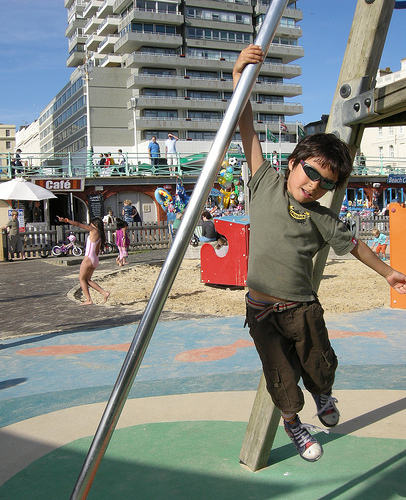

A boy in a a a a pole .


In [18]:
#Predictions
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

def get_encoding(model1, img):
    image = preprocessing(img)
    pred = model1.predict(image).reshape(2048)
    return pred

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

#img = "/content/drive/My Drive/EAI Project/3759492488_592cd78ed1.jpg"

img = "../input/flickerdata/Flickr_Data/Images/3759492488_592cd78ed1.jpg"

test_img = get_encoding(resnet, img)

print(test_img)

def predict_captions(image,model):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        #print("par_caps",par_caps)
        
        
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        #print("par_caps2",par_caps)
        
        
        preds = model.predict([np.array([image]), np.array(par_caps)])
        #print("preds",preds)
        
        word_pred = indices_2_word[np.argmax(preds[0])]
        #print("word_pred",word_pred)
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img,model)

from IPython.display import Image, display
z = Image(filename=img)
display(z)

print(Argmax_Search)

In [22]:
max_len

40

In [23]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
_______________________________________________________________________________________

In [24]:
model.get_weights()

[array([[ 0.1400262 ,  0.01341846,  0.17697524, ..., -0.1056858 ,
         -0.13163112,  0.2582724 ],
        [ 0.04913129,  0.00416944, -0.03750448, ..., -0.02366385,
         -0.03052487, -0.04795147],
        [ 0.32270733,  0.1884051 , -0.08831334, ..., -0.2701477 ,
         -0.02076647, -0.0582202 ],
        ...,
        [-0.07779036, -0.02980095, -0.06372778, ...,  0.03154986,
          0.06589887, -0.13029206],
        [-0.04440036, -0.02945291, -0.02343808, ...,  0.0053352 ,
          0.0300719 ,  0.01872068],
        [ 0.00642125, -0.00898284, -0.01658268, ..., -0.01162434,
         -0.02588502,  0.01035323]], dtype=float32),
 array([[ 0.03440355, -0.03178862, -0.16527067, ...,  0.00715766,
          0.02106253,  0.0016015 ],
        [-0.00523769,  0.07440104,  0.12794493, ..., -0.04567982,
          0.02777277,  0.01115104],
        [ 0.0431133 ,  0.00102437,  0.14917971, ...,  0.14816454,
         -0.05162994, -0.0239755 ],
        ...,
        [-0.0204745 , -0.07512501, -0.0

In [29]:
word_2_indices['a']

4659

In [34]:


import json

with open('file_dict.txt', 'w') as file:
     file.write(json.dumps(word_2_indices))

In [24]:
word_2_indices

{'place': 0,
 'ate': 1,
 'Marathon': 2,
 'Looks': 3,
 'suns': 4,
 'muzzles': 5,
 'streamer': 6,
 'pats': 7,
 'winding': 8,
 'browsing': 9,
 'sparkling': 10,
 'me': 11,
 'grassy': 12,
 'music': 13,
 'Black': 14,
 'squeamish': 15,
 'multilple': 16,
 'precariously': 17,
 'umpire': 18,
 'pauses': 19,
 'SMU': 20,
 'lavish': 21,
 'lapel': 22,
 'paddock': 23,
 'camera-phone': 24,
 'rocky': 25,
 'blocked': 26,
 'sliding': 27,
 'purchasing': 28,
 'magazines': 29,
 'bounds': 30,
 'adjusting': 31,
 'grafitti': 32,
 'snuggles': 33,
 'bicycling': 34,
 'cot': 35,
 'approaches': 36,
 'overgrown': 37,
 'exposure': 38,
 'upside': 39,
 'beverage': 40,
 'headdresses': 41,
 'downsteps': 42,
 'spotters': 43,
 'visible': 44,
 'poolside': 45,
 'blows': 46,
 'dish': 47,
 'stringless': 48,
 'crossing': 49,
 'hippie': 50,
 'jewlery': 51,
 'umbrella': 52,
 'operates': 53,
 'hind': 54,
 'bus': 55,
 'cds': 56,
 'elf': 57,
 'shop': 58,
 'eating': 59,
 'terriers': 60,
 'blond': 61,
 'cooks': 62,
 'duke': 63,
 'grind

In [25]:
indices_2_word

{0: 'UNK',
 1: 'ate',
 2: 'Marathon',
 3: 'Looks',
 4: 'suns',
 5: 'muzzles',
 6: 'streamer',
 7: 'pats',
 8: 'winding',
 9: 'browsing',
 10: 'sparkling',
 11: 'me',
 12: 'grassy',
 13: 'music',
 14: 'Black',
 15: 'squeamish',
 16: 'multilple',
 17: 'precariously',
 18: 'umpire',
 19: 'pauses',
 20: 'SMU',
 21: 'lavish',
 22: 'lapel',
 23: 'paddock',
 24: 'camera-phone',
 25: 'rocky',
 26: 'blocked',
 27: 'sliding',
 28: 'purchasing',
 29: 'magazines',
 30: 'bounds',
 31: 'adjusting',
 32: 'grafitti',
 33: 'snuggles',
 34: 'bicycling',
 35: 'cot',
 36: 'approaches',
 37: 'overgrown',
 38: 'exposure',
 39: 'upside',
 40: 'beverage',
 41: 'headdresses',
 42: 'downsteps',
 43: 'spotters',
 44: 'visible',
 45: 'poolside',
 46: 'blows',
 47: 'dish',
 48: 'stringless',
 49: 'crossing',
 50: 'hippie',
 51: 'jewlery',
 52: 'umbrella',
 53: 'operates',
 54: 'hind',
 55: 'bus',
 56: 'cds',
 57: 'elf',
 58: 'shop',
 59: 'eating',
 60: 'terriers',
 61: 'blond',
 62: 'cooks',
 63: 'duke',
 64: 'gri